# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [1]:
import pandas as pd
import numpy as np
import math
import json
from matplotlib import pyplot as plt

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
print("**************portfolio**************")
print(portfolio.columns)
print("**************profile**************")
print(profile.columns)
print("**************transcript**************")
print(transcript.columns)


**************portfolio**************
Index(['channels', 'difficulty', 'duration', 'id', 'offer_type', 'reward'], dtype='object')
**************profile**************
Index(['age', 'became_member_on', 'gender', 'id', 'income'], dtype='object')
**************transcript**************
Index(['event', 'person', 'time', 'value'], dtype='object')


here as you can see we have null values in profile dataframe in gendor and incomes columns

In [3]:
print(portfolio.isnull().sum())
print("****************************")
print(profile.isnull().sum())
print("****************************")
print(transcript.isnull().sum())


channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64
****************************
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64
****************************
event     0
person    0
time      0
value     0
dtype: int64



### Explore portfolio dataframe
**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)


In [4]:
print(portfolio.shape)
portfolio

(10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [6]:
print(portfolio['offer_type'].value_counts())
print(portfolio['difficulty'].value_counts())
print(portfolio['duration'].value_counts())


discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64
10    4
5     2
0     2
7     1
20    1
Name: difficulty, dtype: int64
7     4
10    2
5     2
4     1
3     1
Name: duration, dtype: int64


### Explore profile dataframe

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [7]:
print(profile.shape)
profile.head()

(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


### Clean Profile Data

Profile dataframe has the most NA values therefore I need to clean it to make the result more accurate

In [9]:
print(profile.isnull().sum())



age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


In [10]:
print(profile['age'].value_counts())



118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64


As you can see in the above cell the age of 118 has the same number of NA values and I concluded all the records with age 118 I need to delete because it will affect the accuracy of the data.

In [11]:
profile.where(profile.age==118).count()


age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [12]:
profile = profile.drop(profile[profile.age==118].index)


In [13]:
bins = [0,12,20,30,40,50,60,70,200]
labels = ['<12', '13-20', '21-30','31-40', '41-50', '51-60','61-70','70+']
profile['agerange'] = pd.cut(profile.age, bins, labels = labels)
profile_age = profile.groupby(['agerange'], as_index=False)['id'].count()
profile_age

,agerange,id
0,<12,0
1,13-20,340
2,21-30,1365
3,31-40,1597
4,41-50,2391
5,51-60,3590
6,61-70,2910
7,70+,2632


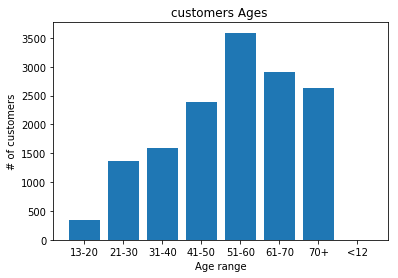

In [14]:
plt.bar(profile_age['agerange'],profile_age['id'])
plt.title('customers Ages ')
plt.xlabel('Age range')
plt.ylabel('# of customers')
plt.show()

In [15]:
gender_g=profile['gender'].value_counts()
gender_g


M    8484
F    6129
O     212
Name: gender, dtype: int64

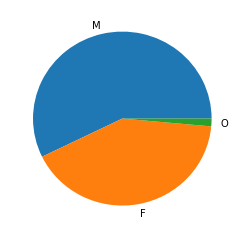

In [16]:

fig = plt.figure(figsize =(4, 4))
plt.pie(gender_g.values, labels = gender_g.index
)
  
# show plot
plt.show()

In [17]:
bins = [30000,40000,50000,60000,70000,80000,90000,100000,120000]
labels = ['30K-40K', '41K-50K', '51K-60K','61K-70K', '71K-80K', '81K-90K','90K-100K','100K+']
profile['income_range'] = pd.cut(profile.income, bins, labels = labels)
profile_income = profile.groupby(['income_range'],as_index=False)['id'].count()
profile_income

,income_range,id
0,30K-40K,2047
1,41K-50K,1899
2,51K-60K,2659
3,61K-70K,2347
4,71K-80K,2220
5,81K-90K,1371
6,90K-100K,1188
7,100K+,1006


Text(0,0.5,'# of Customers')

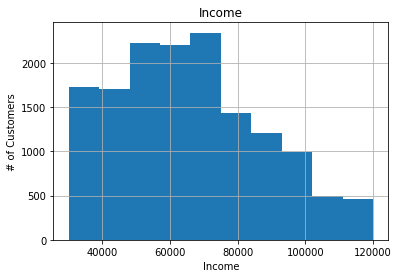

In [18]:
profile.income.hist()
plt.title("Income")
plt.xlabel("Income")
plt.ylabel("# of Customers")

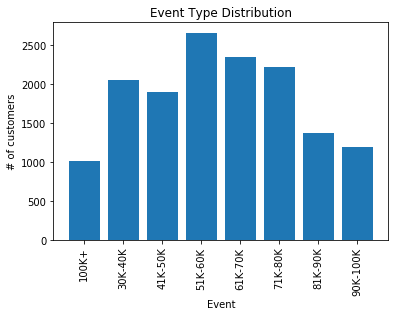

In [19]:
plt.bar(profile_income['income_range'],profile_income['id'])
plt.title('Event Type Distribution')
plt.xlabel('Event')
plt.ylabel('# of customers')
plt.xticks(rotation=90, ha='center')
plt.show()


In [21]:

profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]').dt.year
profile.became_member_on 
profile_join_year = profile.groupby(['became_member_on'],as_index=False)['id'].count()
profile_join_year



,became_member_on,id
0,2013,274
1,2014,662
2,2015,1597
3,2016,3024
4,2017,5599
5,2018,3669


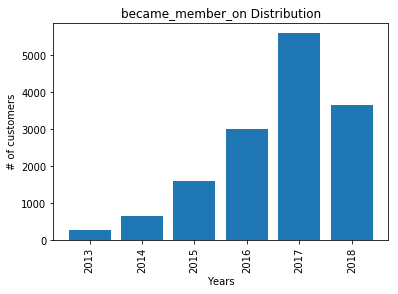

In [22]:
plt.bar(profile_join_year['became_member_on'],profile_join_year['id'])
plt.title('became_member_on Distribution')
plt.xlabel('Years')
plt.ylabel('# of customers')
plt.xticks(rotation=90, ha='center')
plt.show()

### Explore transcript dataframe

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [23]:
print(transcript.shape)
transcript.head()

(306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [24]:
print(transcript.isnull().sum())


event     0
person    0
time      0
value     0
dtype: int64


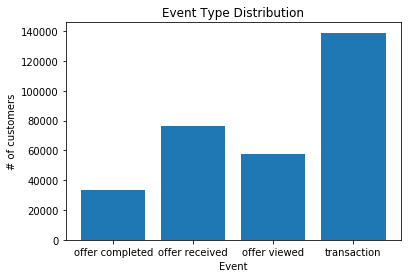

In [25]:
transcript_by_event = transcript['event'].value_counts()
transcript_by_event
plt.bar(transcript_by_event.index,transcript_by_event.values)
plt.title('Event Type Distribution')
plt.xlabel('Event')
plt.ylabel('# of customers')
plt.show()

As you can see here the value column contain many values offer Id ,amount and reward

Here I will separate them all in a different column to do the analysis 

In [26]:

transcript1 = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)



In this step 

1- I will unified offer id and offer_id  columns to be in one column called [all_offer id]

2- Rename Columns

    a. person column to id in transcript
    b. all_offer id to offer id id in transcript
    c.id column to  offer id in portfolio
    
    

In [27]:
transcript2=transcript1

transcript1_test=transcript1
transcript1_test
transcript1_test['all_offer id']=transcript1_test['offer id'].fillna(transcript1_test['offer_id'])
transcript1_test=transcript1_test[['event', 'person', 'time', 'value',  'amount','reward', 'all_offer id']]
transcript1_test.columns=('event', 'id', 'time', 'value',  'amount','reward_transcript', 'offer id')
portfolio.columns=('channels', 'difficulty', 'duration', 'offer id', 'offer_type', 'reward_portfolio')

transcript1_test.columns

transcript1_test.head()

,event,id,time,value,amount,reward_transcript,offer id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


# Data Preprocessing 

### Merge 

#### Here in these steps, I will link data together to analyze the data in depth by merging transcript with profile and portfolio by id and offer id


In [28]:
merge_transcript=pd.merge(transcript1_test,portfolio,on='offer id',how='left')
print(merge_transcript.shape)
merge_transcript.head()


(306534, 12)


,event,id,time,value,amount,reward_transcript,offer id,channels,difficulty,duration,offer_type,reward_portfolio
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo,10.0


In [29]:
merge_transcript=pd.merge(merge_transcript,profile,on='id',how='left')
print(merge_transcript.shape)
merge_transcript.head()

(306534, 18)


,event,id,time,value,amount,reward_transcript,offer id,channels,difficulty,duration,offer_type,reward_portfolio,age,became_member_on,gender,income,agerange,income_range
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo,5.0,75.0,2017.0,F,100000.0,70+,90K-100K
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount,2.0,68.0,2018.0,M,70000.0,61-70,61K-70K
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo,10.0,NaN,NaN,NaN,NaN,NaN,NaN


### Check the NA values

# Corrlation

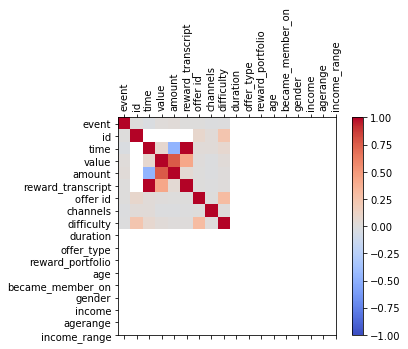

In [30]:


corr = merge_transcript.corr()

# corr = merge_transcript_test.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(merge_transcript.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(merge_transcript.columns)
ax.set_yticklabels(merge_transcript.columns)
plt.show()

In [31]:
merge_transcript_test=merge_transcript
merge_transcript_test['bogo']=np.where(merge_transcript_test['offer_type']=='bogo',1,0)
merge_transcript_test['discount']=np.where(merge_transcript_test['offer_type']=='discount',1,0)
merge_transcript_test['informational']=np.where(merge_transcript_test['offer_type']=='informational',1,0)
merge_transcript_test['offer_completed']=np.where(merge_transcript_test['event']=='offer completed',1,0)
merge_transcript_test['offer_received']=np.where(merge_transcript_test['event']=='offer received',1,0)
merge_transcript_test['offer_viewed']=np.where(merge_transcript_test['event']=='offer viewed',1,0)
merge_transcript_test['transaction']=np.where(merge_transcript_test['event']=='transaction',1,0)


merge_transcript_test.columns

Index(['event', 'id', 'time', 'value', 'amount', 'reward_transcript',
       'offer id', 'channels', 'difficulty', 'duration', 'offer_type',
       'reward_portfolio', 'age', 'became_member_on', 'gender', 'income',
       'agerange', 'income_range', 'bogo', 'discount', 'informational',
       'offer_completed', 'offer_received', 'offer_viewed', 'transaction'],
      dtype='object')

# Event Analysis

Event Type Distribution (%)
event
offer completed    10.954413
offer received     24.883700
offer viewed       18.831516
transaction        45.330371
Name: person, dtype: float64


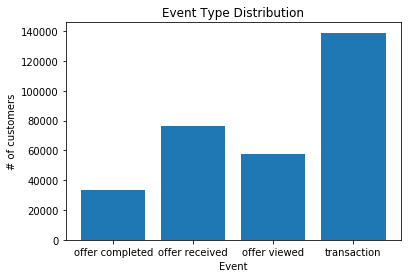

             event  difficulty
0  offer completed    9.269841
1   offer received    7.707723
2     offer viewed    7.213235
3      transaction         NaN


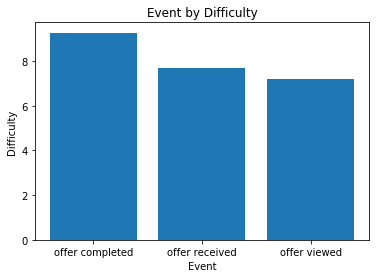

Offer Type By Gender
  gender  offer_completed  offer_received  offer_viewed
0      F            15477           27456         20786
1      M            16466           38129         28301
2      O              501             916           773


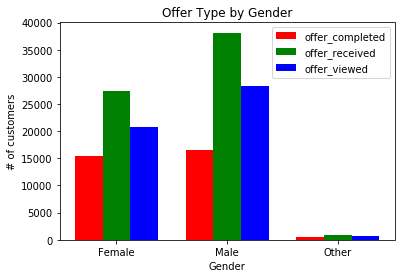

Event By Age
          offer_completed  offer_received  offer_viewed  transaction
agerange                                                            
<12                     0               0             0            0
13-20                 536            1508          1062         3438
21-30                2410            6180          4263        14184
31-40                3193            7202          5286        15851
41-50                5106           10626          8344        19535
51-60                8357           16177         12197        27976
61-70                6717           13062          9865        22664
70+                  6125           11746          8843        20309
Event By income
              offer_completed  offer_received  offer_viewed  transaction
income_range                                                            
30K-40K                  3258            9271          6363        20894
41K-50K                  3174            8444          5820   

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

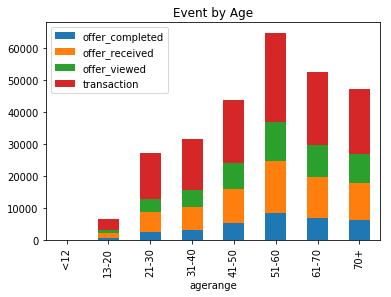

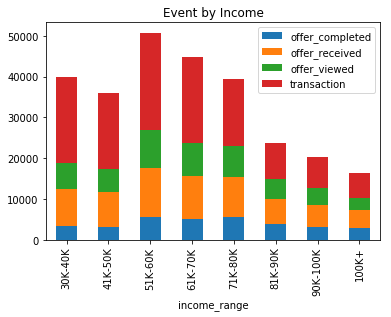

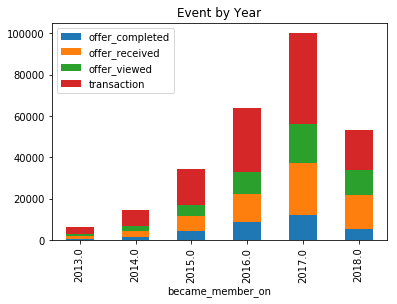

In [32]:
print('Event Type Distribution (%)')
print(transcript1.groupby('event').person.count()/transcript1.shape[0] * 100.00)

transcript_by_event = transcript['event'].value_counts()
transcript_by_event
plt.bar(transcript_by_event.index,transcript_by_event.values)
plt.title('Event Type Distribution')
plt.xlabel('Event')
plt.ylabel('# of customers')
plt.show()


# ***********Event by difficulty************

event_difficulty=merge_transcript_test.groupby(['event'],as_index=False)['difficulty'].mean()

print(event_difficulty)

plt.bar(event_difficulty['event'],event_difficulty['difficulty'])
plt.title('Event by Difficulty')
plt.xlabel('Event')
plt.ylabel('Difficulty')
plt.show()

# ***********Event by Gender************
offer_type_gender_group=merge_transcript_test.groupby(['gender'],as_index=False)['offer_completed','offer_received','offer_viewed'].sum()
print('Offer Type By Gender')

print(offer_type_gender_group)

N = 3
ind = np.arange(N) 
width = 0.25
  
xvals = offer_type_gender_group.offer_completed
bar1 = plt.bar(ind, xvals, width, color = 'r')
  
yvals = offer_type_gender_group.offer_received
bar2 = plt.bar(ind+width, yvals, width, color='g')
  
zvals = offer_type_gender_group.offer_viewed
bar3 = plt.bar(ind+width*2, zvals, width, color = 'b')

# gvals = offer_type_gender_group.transaction
# bar4 = plt.bar(ind+width*4, gvals, width, color = 'b')

plt.xlabel("Gender")
plt.ylabel('# of customers')
plt.title("Offer Type by Gender")
  
plt.xticks(ind+width,['Female', 'Male', 'Other'])
plt.legend( (bar1, bar2, bar3), ('offer_completed', 'offer_received', 'offer_viewed') )
plt.show()


# ***********Event by Age************

event_age=merge_transcript_test.groupby(['agerange'])['offer_completed','offer_received','offer_viewed','transaction'].sum()
# print(merge_transcript_test.groupby(['agerange','event'])['id'].count()/merge_transcript_test.shape[0] * 100.00)

print('Event By Age')
print(event_age)


# Very simple one-liner using our agg_tips DataFrame.
event_age.plot(kind='bar', stacked=True)

# Just add a title and rotate the x-axis labels to be horizontal.
plt.title('Event by Age')
plt.xticks(rotation=90, ha='center')


# ***********Event by Income************

event_income=merge_transcript_test.groupby(['income_range'])['offer_completed','offer_received','offer_viewed','transaction'].sum()
# print(merge_transcript_test.groupby(['agerange','event'])['id'].count()/merge_transcript_test.shape[0] * 100.00)

print('Event By income')
print(event_income)


# Very simple one-liner using our agg_tips DataFrame.
event_income.plot(kind='bar', stacked=True)

# Just add a title and rotate the x-axis labels to be horizontal.
plt.title('Event by Income')
plt.xticks(rotation=90, ha='center')


# ***********Event by became_member_on************

event_year=merge_transcript_test.groupby(['became_member_on'])['offer_completed','offer_received','offer_viewed','transaction'].sum()
# print(merge_transcript_test.groupby(['agerange','event'])['id'].count()/merge_transcript_test.shape[0] * 100.00)

print('Event By income')
print(event_year)


# Very simple one-liner using our agg_tips DataFrame.
event_year.plot(kind='bar', stacked=True)

# Just add a title and rotate the x-axis labels to be horizontal.
plt.title('Event by Year')
plt.xticks(rotation=90, ha='center')

# Offer Type Analysis

Offer Type per customers
      offer_type     id
0           bogo  71617
1       discount  69898
2  informational  26066


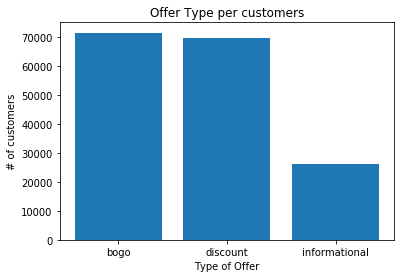

Offer Type By Gender
  gender   bogo  discount  informational
0      F  27619     26652           9448
1      M  35301     34739          12856
2      O    914       920            356


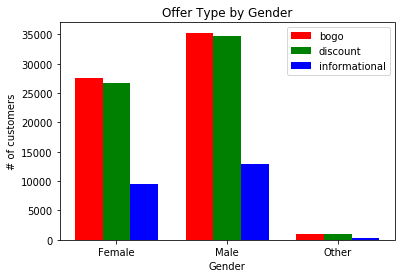

           bogo  discount  informational
agerange                                
<12           0         0              0
13-20      1402      1185            519
21-30      5491      5411           1951
31-40      6611      6644           2426
41-50     10448      9903           3725
51-60     15716     15402           5613
61-70     12637     12672           4335
70+       11529     11094           4091


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

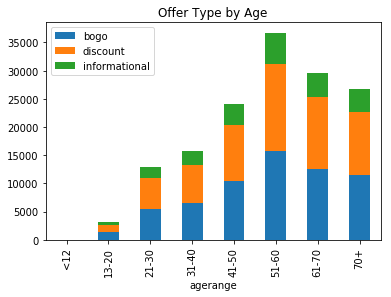

In [33]:
# ***********Offer Type per customers************

offer_type_group=merge_transcript.groupby(['offer_type'],as_index=False)['id'].count()
print('Offer Type per customers')
print(offer_type_group)

plt.bar(offer_type_group['offer_type'],offer_type_group['id'])
plt.title('Offer Type per customers')
plt.xlabel('Type of Offer')
plt.ylabel('# of customers')
plt.show()

# ***********Offer Type by Gender************
offer_type_gender_group=merge_transcript_test.groupby(['gender'],as_index=False)['bogo','discount','informational'].sum()
print('Offer Type By Gender')

print(offer_type_gender_group)

N = 3
ind = np.arange(N) 
width = 0.25
  
xvals = offer_type_gender_group.bogo
bar1 = plt.bar(ind, xvals, width, color = 'r')
  
yvals = offer_type_gender_group.discount
bar2 = plt.bar(ind+width, yvals, width, color='g')
  
zvals = offer_type_gender_group.informational
bar3 = plt.bar(ind+width*2, zvals, width, color = 'b')
  
plt.xlabel("Gender")
plt.ylabel('# of customers')
plt.title("Offer Type by Gender")
  
plt.xticks(ind+width,['Female', 'Male', 'Other'])
plt.legend( (bar1, bar2, bar3), ('bogo', 'discount', 'informational') )
plt.show()


# ***********Offer Type by Age************

Offer_type_age=merge_transcript_test.groupby(['agerange'])['bogo','discount','informational'].sum()
# print('Offer Type By Age')
print(Offer_type_age)


# Very simple one-liner using our agg_tips DataFrame.
Offer_type_age.plot(kind='bar', stacked=True)

# Just add a title and rotate the x-axis labels to be horizontal.
plt.title('Offer Type by Age')
plt.xticks(rotation=90, ha='center')

# Relations Between Events & Offer Types

                  bogo  discount  informational
event                                          
offer completed  15669     17910              0
offer received   30499     30543          15235
offer viewed     25449     21445          10831
transaction          0         0              0


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

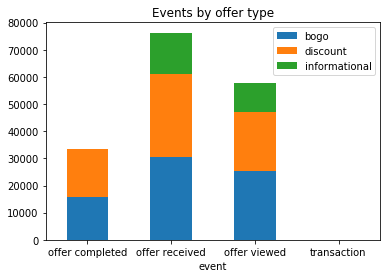

In [34]:
event_offer_Type=merge_transcript_test.groupby(['event'])['bogo','discount','informational'].sum()
print(event_offer_Type)
# Very simple one-liner using our agg_tips DataFrame.
event_offer_Type.plot(kind='bar', stacked=True)

# Just add a title and rotate the x-axis labels to be horizontal.
plt.title('Events by offer type')

plt.xticks(rotation=0, ha='center')

# Who's Utlized the Offers by Age 

          use_offer_%  transaction_%
agerange                            
<12               NaN            NaN
13-20       47.463325      52.536675
21-30       47.538558      52.461442
31-40       49.730433      50.269567
41-50       55.206255      44.793745
51-60       56.765110      43.234890
61-70       56.672020      43.327980
70+         56.810497      43.189503


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

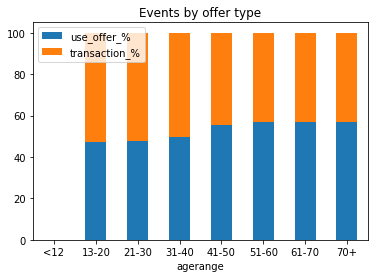

In [35]:
test=merge_transcript_test
test['use_offer']=test['offer_completed']+test['offer_received']+test['offer_viewed']
test_g=test.groupby(['agerange'])['use_offer','transaction'].sum()
test_g['total']=test_g['use_offer']+test_g['transaction']
test_g['use_offer_%']=test_g['use_offer']/test_g['total']*100
test_g['transaction_%']=test_g['transaction']/test_g['total']*100
test_g=test_g[['use_offer_%', 'transaction_%']]
print(test_g)
# ***********Offer Type by Gender************

# Very simple one-liner using our agg_tips DataFrame.
test_g.plot(kind='bar', stacked=True)

# Just add a title and rotate the x-axis labels to be horizontal.
plt.title('Events by offer type')

plt.xticks(rotation=0, ha='center')

# The most successful offers 

                           offer id     offer_type  success_%
6  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo  26.873226
9  fafdcd668e3743c1bb461111dcafc2a4       discount  26.268465
1  2298d6c36e964ae4a3e7e9706d1fb8c2       discount  25.602066
2  2906b810c7d4411798c6938adc9daaa5       discount  25.477263
0  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount  24.870918
8  f19421c1d4aa40978ebb69ca19b0e20d           bogo  22.455700
7  ae264e3637204a6fb9bb56bc8210ddfd           bogo  20.418558
4  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo  18.280101
3  3f207df678b143eea3cee63160fa8bed  informational   0.000000
5  5a8bc65990b245e5a138643cd4eb9837  informational   0.000000


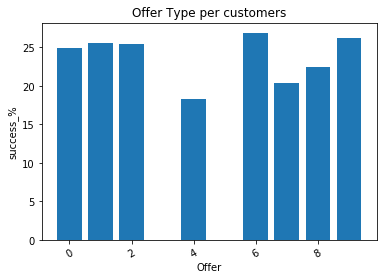

In [36]:
test=merge_transcript_test
test['use_offer']=test['offer_completed']+test['offer_received']+test['offer_viewed']+test['transaction']
test_g=test.groupby(['offer id','offer_type'],as_index=False)['use_offer','offer_completed'].sum()
test_g['success_%']=test_g['offer_completed']/test_g['use_offer']*100
# test_g['transaction_%']=test_g['transaction']/test_g['total']*100
test_g=test_g[['offer id','offer_type','success_%']]
test_g=test_g.sort_values('success_%', ascending=False)

print(test_g)
# ***********Offer Type by Gender************
plt.bar(test_g.index,test_g['success_%'])
plt.title('Offer Type per customers')
plt.xlabel('Offer')
plt.ylabel('success_%')
plt.xticks(rotation=30, ha='center')
plt.show()


# Difficulty Analysis

Event by Difficulty
             event  difficulty
0  offer completed    9.269841
1   offer received    7.707723
2     offer viewed    7.213235
3      transaction         NaN


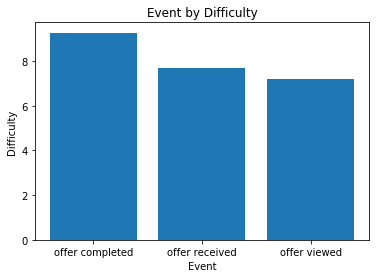

Offer Type by Difficulty
      offer_type  difficulty
0           bogo    7.533197
1       discount   11.102936
2  informational    0.000000


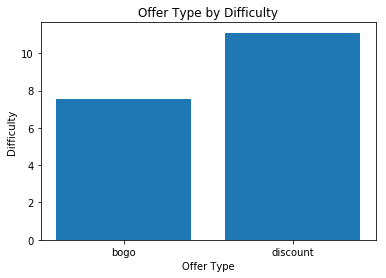

In [37]:
#************Event by Difficulty*************
event_difficulty=merge_transcript_test.groupby(['event'],as_index=False)['difficulty'].mean()
print('Event by Difficulty')
print(event_difficulty)

plt.bar(event_difficulty['event'],event_difficulty['difficulty'])
plt.title('Event by Difficulty')
plt.xlabel('Event')
plt.ylabel('Difficulty')
plt.show()

#************Offer Type by Difficulty*************

offer_type_difficulty=merge_transcript_test.groupby(['offer_type'],as_index=False)['difficulty'].mean()
print('Offer Type by Difficulty')
print(offer_type_difficulty)
offer_type_difficulty=offer_type_difficulty.drop(offer_type_difficulty[offer_type_difficulty.difficulty==0].index)


plt.bar(offer_type_difficulty['offer_type'],offer_type_difficulty['difficulty'])
plt.title('Offer Type by Difficulty')
plt.xlabel('Offer Type')
plt.ylabel('Difficulty')
plt.show()

In [38]:
duration_difficulty=merge_transcript_test.groupby(['duration'],as_index=False)['difficulty'].mean()
print(duration_difficulty)


   duration  difficulty
0       3.0    0.000000
1       4.0    0.000000
2       5.0    7.439162
3       7.0    7.984509
4      10.0   14.045364


In [39]:
merge_transcript_test.corr()

,time,amount,reward_transcript,difficulty,duration,reward_portfolio,age,became_member_on,income,bogo,discount,informational,offer_completed,offer_received,offer_viewed,transaction,use_offer
time,1.000000,0.004678,-0.023602,0.022529,0.024917,0.005501,0.002068,-0.008416,-0.003443,-0.035980,-0.020997,-0.037156,0.060702,-0.097121,-0.029075,0.069098,NaN
amount,0.004678,1.000000,NaN,NaN,NaN,NaN,0.091624,0.030967,0.237198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reward_transcript,-0.023602,NaN,1.000000,0.070550,-0.466142,1.000000,0.030248,0.024863,0.074120,0.756817,-0.756817,NaN,NaN,NaN,NaN,NaN,NaN
difficulty,0.022529,NaN,0.070550,1.000000,0.768318,0.425746,0.009898,-0.008276,0.026340,-0.054274,0.544936,-0.667311,0.140733,-0.025829,-0.091479,NaN,NaN
duration,0.024917,NaN,-0.466142,0.768318,1.000000,0.049923,0.006579,-0.013612,0.015368,-0.264435,0.731885,-0.634794,0.167688,-0.045798,-0.093258,NaN,NaN
reward_portfolio,0.005501,NaN,1.000000,0.425746,0.049923,1.000000,0.000911,-0.000117,0.014786,0.797281,-0.386575,-0.562326,0.071856,-0.059149,0.001458,NaN,NaN
age,0.002068,0.091624,0.030248,0.009898,0.006579,0.000911,1.000000,0.006900,0.298744,0.029148,0.031582,0.012949,0.041575,0.017100,0.021664,-0.058592,NaN
became_member_on,-0.008416,0.030967,0.024863,-0.008276,-0.013612,-0.000117,0.006900,1.000000,0.009308,0.053782,0.047485,0.038167,-0.009052,0.076686,0.060139,-0.106925,NaN
income,-0.003443,0.237198,0.074120,0.026340,0.015368,0.014786,0.298744,0.009308,1.000000,0.058165,0.058026,0.015776,0.088102,0.027654,0.033497,-0.107128,NaN
bogo,-0.035980,NaN,0.756817,-0.054274,-0.264435,0.797281,0.029148,0.053782,0.058165,1.000000,-0.300084,-0.168324,0.193130,0.226080,0.235895,-0.502774,NaN


## Split the data into training and testing data
 

In [40]:
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
    from sklearn.linear_model import LogisticRegression

    from sklearn.naive_bayes import GaussianNB 
    from sklearn.neighbors import KNeighborsClassifier
    import seaborn as sns

    X=merge_transcript_test[['time','amount','offer id',
       'channels', 'difficulty', 'duration',
       'reward_portfolio', 'age', 'became_member_on', 'gender', 'income',
       'agerange', 'income_range', 'bogo', 'discount', 'informational']]
       
    
#     X=merge_transcript_test[['difficulty', 'duration', 'offer_type',
#         'age', 'became_member_on', 'gender', 'income',
#        'agerange', 'income_range', 'bogo', 'discount', 'informational']]
    
    y=merge_transcript_test['offer_completed']
    X = X.apply(pd.to_numeric, errors='coerce')
    y = y.apply(pd.to_numeric, errors='coerce')
    X.fillna(0, inplace=True)
    y.fillna(0, inplace=True)

    #Split to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)


## Predictive Modeling


In [41]:
def evaluate_model_performance(model_name,X_train, y_train, X_test, y_test):
    '''
    input: the model to be used
    X_train, y_train, X_test, y_test
    output:
    output containg training score and testing score
    '''
    output = {}
    clf = model_name   
    clf = clf.fit(X_train, y_train)
    predictions_test = clf.predict(X_test)
    predictions_train = clf.predict(X_train)
     
    #calculate training accuracy 
    output['training_score']= clf.score(X_train,y_train)
    
    #calculate testing accuracy 
    output['testing_score']= clf.score(X_test,y_test)
    
    return output

In [42]:
evaluate_model_performance( DecisionTreeClassifier() ,X_train, y_train, X_test, y_test)


{'training_score': 0.98724443429508835, 'testing_score': 0.88529920292297826}

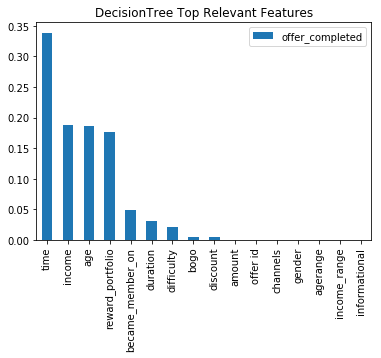

In [43]:
Model_res=DecisionTreeClassifier().fit(X_train,y_train)
importances = Model_res.feature_importances_

# Plot
feat_imp = pd.DataFrame(Model_res.feature_importances_, index=X.columns, columns=['offer_completed']).sort_values('offer_completed',ascending=False)
feat_imp.plot.bar()
plt.title('DecisionTree Top Relevant Features')
plt.show()

In [44]:
evaluate_model_performance( RandomForestClassifier() ,X_train, y_train, X_test, y_test)


{'training_score': 0.9789209266776342, 'testing_score': 0.87815486999923886}

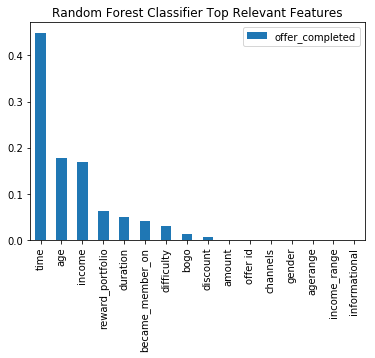

In [51]:
Model_res=RandomForestClassifier().fit(X_train,y_train)
importances = Model_res.feature_importances_

# Plot
feat_imp = pd.DataFrame(Model_res.feature_importances_, index=X.columns, columns=['offer_completed']).sort_values('offer_completed',ascending=False)
feat_imp.plot.bar()
plt.title('Random Forest Classifier Top Relevant Features')
plt.show()

In [46]:
evaluate_model_performance( GradientBoostingClassifier() ,X_train, y_train, X_test, y_test)


{'training_score': 0.91350263080629901, 'testing_score': 0.91197355400658975}

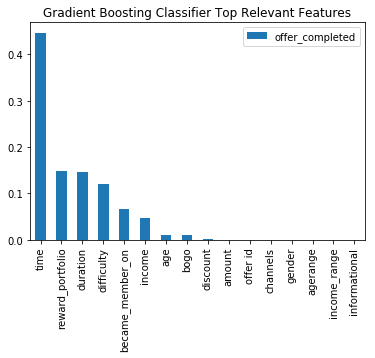

In [52]:
Model_res=GradientBoostingClassifier().fit(X_train,y_train)
importances = Model_res.feature_importances_

# Plot
feat_imp = pd.DataFrame(Model_res.feature_importances_, index=X.columns, columns=['offer_completed']).sort_values('offer_completed',ascending=False)
feat_imp.plot.bar()
plt.title('Gradient Boosting Classifier Top Relevant Features')
plt.show()

In [48]:
evaluate_model_performance( LogisticRegression() ,X_train, y_train, X_test, y_test)

{'training_score': 0.87307349946172164, 'testing_score': 0.87095616620088956}

In [49]:
evaluate_model_performance( GaussianNB() ,X_train, y_train, X_test, y_test)


{'training_score': 0.69054820503977665, 'testing_score': 0.69078196191863939}

In [50]:
evaluate_model_performance( KNeighborsClassifier() ,X_train, y_train, X_test, y_test)


{'training_score': 0.92435208530430202, 'testing_score': 0.89464011918095709}

# Conclusion

![jj](data/dashboard_e.jpg)


In this project the results show customers always respond to BOGO offers more than discount offers because the difficulty in BOGO is less than the discount, and I observe the most of the customers are in the age range between 50-61 years and the income range between  50,000 to 61,000 and men is more likely to purchase than women.


to predict the customer's response, I build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has mainly two steps. First, I merge portfolio, profile, and transaction data and I compared the performance between these models :

1-DecisionTreeClassifier

2-RandomForestClassifier

3-GradientBoostingClassifier

4-LogisticRegression

5-GaussianNB

6-KNeighborsClassifier
 

This analysis suggests that a Decision Tree Classifier model has the best training data accuracy the results shows training data accuracy of 0.98 and the test data set accuracy of 0.89.

after using machine learning models to predict if the customers will respond to the offer or not, the models also show the main factors that will highly affect the possibility of customer's getting an offer are:

1-Time 

2-Age

3- Income

4- length of membership

5-Duration 

6- Difficulty
